# Bike Calculator

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import datetime
import math
import numpy as np
import glob
import os
import pandas as pd
import json
from IPython.display import display, Markdown, HTML
import matplotlib.pyplot as plt

G = 9.81

In [396]:
# Default values. Change these.
BODY_WEIGHT = 80
BIKE_WEIGHT = 13
AVG_POWER = 157
MAX_POWER = 355
MIN_SPEED = 5
MIN_CADENCE = 42
MAX_CADENCE = 100
CHAINRING = 34
MAX_TORQUE = MAX_POWER / MIN_CADENCE
TIRE_SIZE = (700,30)

CASSETTES = {
    '11-32T': [11,12,13,14,16,18,20,22,25,28,32],  # Shimano 11-32T
    '11-34T': [11,13,15,17,19,21,23,25,27,30,34],  # Shimano 11-34T
    '11-36T': [11,12,13,15,17,19,22,25,28,32,36],  # SRAM RIVAL22 PG-1130 11SP 11-36T
    '11-40T': [11,13,15,17,19,21,24,27,31,35,40],  # SHIMANO DEORE XT CS-M8000
}

# table: https://www.cateye.com/data/resources/Tire_size_chart_ENG_151106.pdf
wheel_circumferes_mm = {
    (700,25): 2105,
    (700,28): 2136,
    (700,30): 2146,
    (700,38): 2180,
}

# From bikecalculator.com
# view-source:http://bikecalculator.com/bikecalculator.js
CRR = {
    'clincher': 0.005, 
    'tubular': 0.004, 
    'mtb': 0.012
}

FRONTAL_AREA = {
    'hoods': 0.388, 
    'bartops': 0.445, 
    'barends': 0.420, 
    'drops': 0.300, 
    'aerobar': 0.233, 
    'xxx': 0.200
}


## Bike Physics

In [353]:
def calculate_air_density(altitude, temperature=25):
    return (1.293 - 0.00426 * temperature) * math.exp(-altitude / 7000.0)

# From https://www.michael-konczer.com/en/training/calculators/bike-speed-and-power-calculator
# (original code: https://www.michael-konczer.com/javascript/speed-and-power.js)
def calculate_air_density2(altitude, temperature=25):
    # Conczer
    # constants used
    Rs = 287.058
    normPressure = 101325

    temperature = temperature + 273.15     # convert from °C to K
    airPressure = normPressure * math.pow((1 - (6.5 * altitude / 288000)), 5.256)
    airDensity = airPressure / (Rs * temperature)

    return airDensity


def calculate_power_2(distance, ascent, speed, body_weight, bike_weight,
                    drag=0.3, rolling_drag=0.01, air_density=1.17):
    # Conczer
    results = dict()
    total_weight = body_weight + bike_weight

    # calculate
    results['time'] = pd.Timedelta(seconds=distance * 3600 / 1000 / speed)

    gradient = ascent / (math.sqrt(distance**2 - ascent**2))
    speed_ms = speed / 3.6
    ascend_speed = gradient * speed_ms / (math.sqrt(1 + gradient**2))

    results['gradient'] = gradient
    results['power_air'] = drag * 0.5 * air_density * speed_ms**3
    results['power_rolling'] = total_weight * G * rolling_drag * speed_ms
    results['power_ascent'] = total_weight * G * ascend_speed

    results['power_total'] = results['power_air'] + results['power_rolling'] + \
                             results['power_ascent']
    results['wkg'] = results['power_total'] / body_weight

    return results


def calculate_speed_2(distance, ascent, power_total, body_weight, bike_weight, 
                      position='hoods', tyre='clincher', altitude=100, temperature=25):
    # Conczer
    b = 0
    c = 0
    p = 0
    q = 0
    D = 0
    rolling_drag = CRR[tyre]
    air_density = calculate_air_density(altitude, temperature)
    drag = 0.5 * FRONTAL_AREA[position] * air_density
    total_weight = body_weight + bike_weight
    k = ascent / (math.sqrt(distance**2 - ascent**2))
    speed = 0

    # solve formula of 3rd order
    b = 2 * total_weight * G / (drag * air_density) * (rolling_drag + k / math.sqrt(1 + k**2))
    p = b
    c = -2 * power_total / (drag * air_density)
    q = c
    D = q**2 / 4 + p**3 / 27

    # check which case to us
    if (D > 0):
        speed = math.pow((-q / 2 + math.sqrt(D)), 1/3) - math.pow((q / 2 + math.sqrt(D)), 1/3)

    speed = speed * 3.6
    return speed


def newton(aero, hw, tr, tran, p):
    vel = 20       # Initial guess
    TOL = 0.05     # tolerance
    for i in range(1, 11):
        tv = vel + hw
        aeroEff = aero if (tv > 0.0) else  -aero # wind in face, must reverse effect
        f = vel * (aeroEff * tv**2 + tr) - tran * p # the function
        fp = aeroEff * (3.0 * vel + hw) * tv + tr     # the derivative
        vNew = vel - f / fp
        if (abs(vNew - vel) < TOL):
            return vNew  # success
        vel = vNew

    assert False
    return 0.0  # failed to converge


# From bikecalculator.com
# view-source:http://bikecalculator.com/bikecalculator.js
def calculate_speed(distance, ascent, power, body_weight, bike_weight, 
                    position='hoods', tire='clincher', altitude=100, temperature=25,
                    headwind=0):
    # distance, ascent: meter
    # power: watt
    # weights: kg
    # headwind: kph
    total_weight = body_weight + bike_weight
    crr = CRR[tire];
    frontalArea = FRONTAL_AREA[position]
    grade = ascent / distance
    headwind /= 3.6  # converted to m/s
    transv = 0.95 # no one knows what this is, so why bother presenting a choice?
    
    # Common calculations
    density = calculate_air_density(altitude, temperature)
    twt = 9.8 * total_weight  # total weight in newtons
    A2 = 0.5 * frontalArea * density  # full air resistance parameter
    tres = twt * (grade + crr) # gravity and rolling resistance
    
    v = newton(A2, headwind, tres, transv, power) * 3.6      # convert to km/h
    return v


# From bikecalculator.com
def calculate_power(distance, ascent, speed, body_weight, bike_weight, 
                    position='hoods', tire='clincher', altitude=100, temperature=25,
                    headwind=0):
    total_weight = body_weight + bike_weight
    crr = CRR[tire];
    frontalArea = FRONTAL_AREA[position]
    grade = ascent / distance
    headwind /= 3.6  # converted to m/s
    transv = 0.95 # no one knows what this is, so why bother presenting a choice?
    
    # Common calculations
    density = calculate_air_density(altitude, temperature)
    twt = 9.8 * total_weight  # total weight in newtons
    A2 = 0.5 * frontalArea * density  # full air resistance parameter
    tres = twt * (grade + crr) # gravity and rolling resistance
    
    v = speed / 3.6 # converted to m/s
    tv = v + headwind
    A2Eff = A2 if (tv > 0.0) else -A2 # wind in face, must reverse effect
    power = (v * tres + v * tv**2 * A2Eff) / transv

    return power


# Reference: http://www.tariksaleh.com/bike/geartospeed.pdf
def cadence_at_speed(speed, chainring, cassette, tire_size):
    wheel_circ = wheel_circumferes_mm[tire_size] / 1000
    ratio = chainring / cassette
    minutes = 60
    development = wheel_circ * ratio
    cadence = speed * 1000 / development / minutes
    return round(cadence)


def speed_at_cadence(cadence, chainring, cassette, tire_size):
    wheel_circ = wheel_circumferes_mm[tire_size] / 1000
    ratio = chainring / cassette
    development = wheel_circ * ratio
    speed = development * cadence * 60 / 1000
    return speed



## Power at speed: power to maintain speed at various gradients


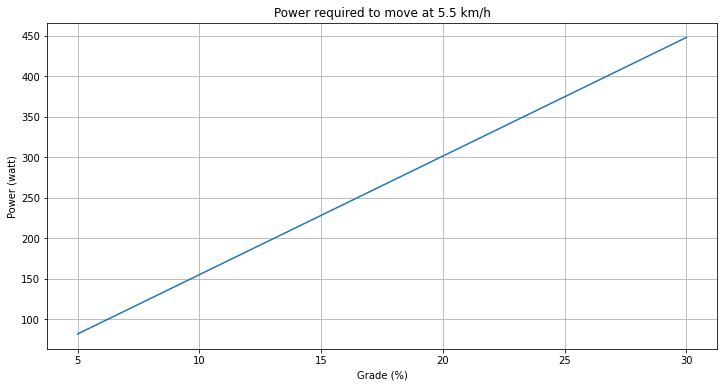

In [362]:
def power_at_speed(speed):
    grades = pd.Series(np.arange(5,31))
    powers = grades.apply(lambda grade: calculate_power(1000, 1000*grade/100, speed, 
                                                        BODY_WEIGHT, BIKE_WEIGHT))
    df = pd.DataFrame({'grade': grades, 'power': powers}).set_index('grade')
    
    fig = plt.figure(figsize=(12,6))
    
    ax = df['power'].plot()
    ax.set_title(f'Power required to move at {speed} km/h')
    ax.set_xlabel('Grade (%)')
    ax.set_ylabel('Power (watt)')
    ax.grid()
    plt.show()

# Test
power_at_speed(5.5)

## Cadence at power: speed/cadence at specified power/chainring/cog

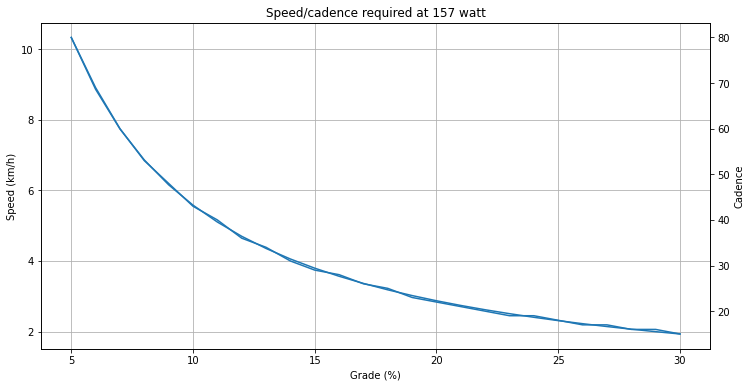

In [273]:
def cadence_at_power(power, chainring, cog, tire_size=(700,30)):
    grades = pd.Series(np.arange(5,31))
    speeds = grades.apply(lambda grade: calculate_speed(1000, 1000*grade/100, power, 
                                                        BODY_WEIGHT, BIKE_WEIGHT))
    cadences = speeds.apply(lambda s: cadence_at_speed(s, chainring, cog, tire_size))
    
    df = pd.DataFrame({'grade': grades, 'speed': speeds, 'cadence': cadences}).set_index('grade')
    
    fig = plt.figure(figsize=(12,6))
    
    ax = df['speed'].plot()
    ax.set_title(f'Speed/cadence required at {power} watt')
    ax.set_xlabel('Grade (%)')
    ax.set_ylabel('Speed (km/h)')
    ax.grid()
    
    ax2 = ax.twinx()
    df['cadence'].plot(ax=ax2)
    ax2.set_ylabel('Cadence')
    
    plt.show()

# Test
cadence_at_power(157, 34, 34, (700,30))

## Utility: Max Torque Finder

Find maximum torque of an activity, where `torque = power / cadence`.

In [93]:
from ztraining import ZwiftTraining

In [274]:
def find_max_torque(file, duration):
    df, meta = ZwiftTraining.parse_file(file, sport='cycling')
    df = df.set_index('dtime')
    df = df[['power', 'cadence', 'speed', 'hr']]
    df = df[ df['power'] > 50 ]
    df = df[ df['cadence'] > 10 ]
    df['power ma'] = df['power'].rolling(duration).mean()
    df['cadence ma'] = df['cadence'].rolling(duration).mean()
    df['torque ma'] = df['power ma'] / df['cadence ma']
    df['speed ma'] = df['speed'].rolling(duration).mean()
    
    print(f'Max {duration}s power:')
    ploc = df['power ma'].idxmax()
    #print(df.loc[ploc])
    row = df.loc[ploc]
    print(row[['power ma', 'cadence ma', 'speed ma', 'torque ma']])
    print('')
    
    print(f'Max {duration}s torque:')
    tloc = df['torque ma'].idxmax()
    row = df.loc[tloc]
    #print(df.loc[tloc])
    print(row[['power ma', 'cadence ma', 'speed ma', 'torque ma']])

    
dir = '/home/bennylp/Desktop/tmp/import activities/'
files = [
    'Yogya_Ultra_Challenge_YUCC_200km_dnf_.gpx',
    'GG_Kesiman.gpx',
    '04 Mbolang_ke_Malang_Batu_Cangar.gpx',
    '03 Pacet.gpx',
    'Nongkojajar.fit',
]

for f in files:
    f = os.path.join(dir, f)
    display(Markdown('### ' + os.path.basename(f)))
    #print('-' * 40)
    find_max_torque(f, 5)
    print('')

### Yogya_Ultra_Challenge_YUCC_200km_dnf_.gpx

Max 5s power:
power ma      401.60000
cadence ma     70.30000
speed ma       29.34400
torque ma       5.71266
Name: 2022-01-29 07:07:55, dtype: float64

Max 5s torque:
power ma      245.200000
cadence ma     29.800000
speed ma        7.638000
torque ma       8.228188
Name: 2022-01-29 12:16:51, dtype: float64



### GG_Kesiman.gpx

Max 5s power:
power ma      403.300000
cadence ma     57.700000
speed ma        7.058000
torque ma       6.989601
Name: 2022-02-26 08:19:53, dtype: float64

Max 5s torque:
power ma      355.300000
cadence ma     42.600000
speed ma       10.136000
torque ma       8.340376
Name: 2022-02-26 09:56:45, dtype: float64



### 04 Mbolang_ke_Malang_Batu_Cangar.gpx

Max 5s power:
power ma      371.9000
cadence ma     62.5000
speed ma       24.0980
torque ma       5.9504
Name: 2022-01-16 17:52:10, dtype: float64

Max 5s torque:
power ma      227.800000
cadence ma     29.600000
speed ma       16.054000
torque ma       7.695946
Name: 2022-01-16 10:47:41, dtype: float64



### 03 Pacet.gpx

Max 5s power:
power ma      383.000000
cadence ma     64.500000
speed ma       24.218000
torque ma       5.937984
Name: 2022-01-09 14:37:46, dtype: float64

Max 5s torque:
power ma      293.900000
cadence ma     44.600000
speed ma       13.840000
torque ma       6.589686
Name: 2022-01-09 12:34:55, dtype: float64



### Nongkojajar.fit

Max 5s power:
power ma      390.700000
cadence ma     83.400000
speed ma       37.732000
torque ma       4.684652
Name: 2022-01-22 13:36:28, dtype: float64

Max 5s torque:
power ma      251.700000
cadence ma     31.300000
speed ma        8.080000
torque ma       8.041534
Name: 2022-01-22 13:17:44, dtype: float64



## Gradients Summary of GPX/TCX/FIT file

Calculate the total distance and eg of each gradient in a GPX/TCX/FIT file. Plot it too for visualization.

In [422]:
def summarize_gradients(file, min_grad=1, max_grad=50, min_mov=2, ma_period=3):
    df, meta = ZwiftTraining.parse_file(file, sport='cycling')
    df['eg'] = df['elevation'].diff()
    df['grade'] = (df['eg'] / df['movement']).fillna(0.0)
    df['grade ma'] = df['grade'].rolling(ma_period).mean().fillna(0.0)
    df['grade ma'] = (df['grade ma'] * 100).astype(int)
    
    df = df[['distance', 'elevation', 'movement', 'eg', 'grade ma']]
    
    summary = df.groupby('grade ma').agg('sum')
    summary = summary[['movement', 'eg']].round(0).astype(int)
    summary = summary.loc[min_grad:max_grad,:]
    summary = summary[ summary['movement'] >= min_mov ]
    return summary


def plot_gradients(files, min_grad=1, max_grad=35):
    grad_summaries = {}
    for f in files:
        title = os.path.basename(f)
        df = summarize_gradients(f)
        grad_summaries[title] = df
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    for i, (title, df) in enumerate(grad_summaries.items()):
        df = df.loc[min_grad:max_grad,:]
        df['movement'].plot(ax=ax, color=f'C{i}', label=title)
        ax.set_xlabel('Grade (%)')
        ax.set_ylabel('Total distance (m)')
        ax.grid()
        ax.legend()
    plt.show()

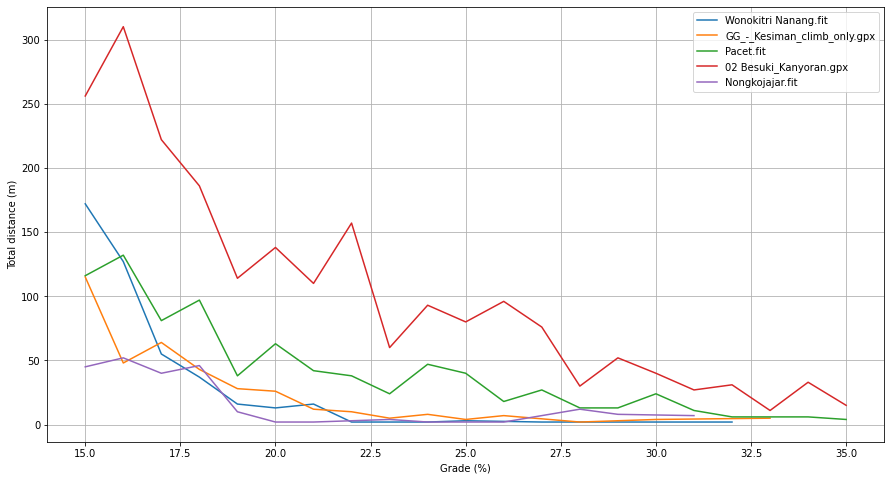

In [407]:
# Interesting climbs in Jatim
dir = '/home/bennylp/Desktop/tmp/import activities/'
filenames = [
    'Wonokitri Nanang.fit',
    'GG_-_Kesiman_climb_only.gpx',
    'Pacet.fit',
    '02 Besuki_Kanyoran.gpx',
    'Nongkojajar.fit',
]
files = [os.path.join(dir, f) for f in filenames]

plot_gradients(files)

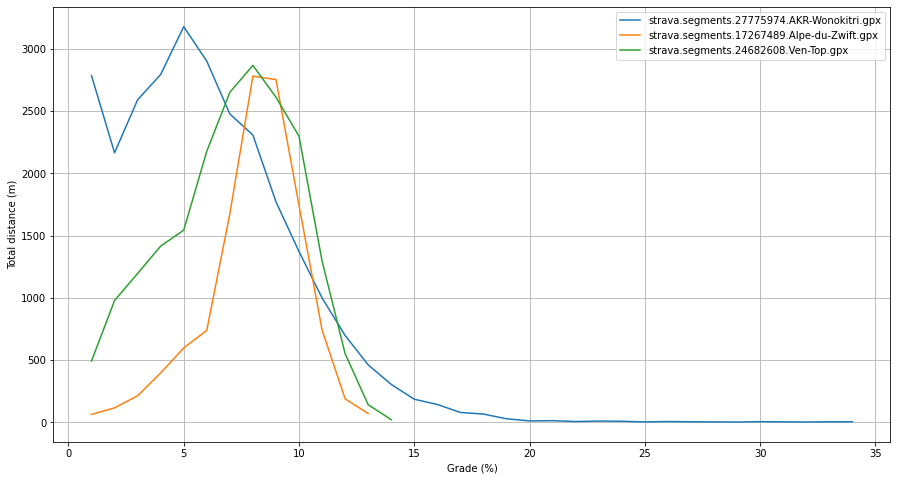

In [423]:
dir = '/home/bennylp/Desktop/tmp/export-segments/'
filenames = [
    'strava.segments.27775974.AKR-Wonokitri.gpx',
    'strava.segments.17267489.Alpe-du-Zwift.gpx',
    'strava.segments.24682608.Ven-Top.gpx',
]
files = [os.path.join(dir, f) for f in filenames]
plot_gradients(files)

## Power Cadence and Cog at Grade

Calculate the "optimal" cog selection, cadence, and speed for each gradient given the specified average power, max power, minimum speed, minimum cadence, max torque, body weight, bike weight, and tire size parameters.

In [430]:
def power_cadence_cog_at_grade(avg_power, max_power, min_speed, min_cadence, 
                               chainring, cogs, max_torque, max_cadence=MAX_CADENCE,
                               body_weight=BODY_WEIGHT, bike_weight=BIKE_WEIGHT,
                               min_grade=5, max_grade=20, tire_size=(700,30)):
    cogs = sorted(cogs)
    all_grades = np.arange(min_grade,max_grade+1)
    grades = []
    powers = []
    wkgs = []
    speeds = []
    cadences = []
    best_cogs = []
    
    for grade in all_grades:
        best_cog = None
        best_cad = None
        best_power = None
        best_speed = None
        for power in range(avg_power, max_power, 5):
            if power != avg_power:
                power = power // 5 * 5
            for cog in cogs:
                speed = calculate_speed(1000, 1000*grade/100, power, body_weight, bike_weight)
                if speed < min_speed:
                    continue
                cad = cadence_at_speed(speed, chainring, cog, tire_size)
                torque = power / cad
                if cad >= min_cadence and torque < max_torque:
                    #print(f'grade: {grade}, power: {power}, cog: {cog}, cad: {cad}')
                    if cad > max_cadence and best_cog is not None:
                        break
                    best_cog = cog
                    best_cad = cad
                    best_power = power
                    best_speed = speed
                    #break
                    
            if best_cog is not None:
                break
                
        if not best_cog:
            print(f'Unable to cycle at grade {grade}% or above. '
                   'Unable to satisfy min_cadence, min_speed, or max_torque using '
                   'the specified max_power/cogs')
            break
        
        #print(f'{grade}%: {power} W, {speed:.1f} km/h, {cad} RPM, cog: {best_cog}')
        
        grades.append(grade)
        powers.append(best_power)
        wkgs.append(best_power / body_weight)
        speeds.append(best_speed)
        cadences.append(best_cad)
        best_cogs.append(best_cog)
    
    df = pd.DataFrame({'grade (%)': grades, 'power': powers, 'w/kg': wkgs,
                       'speed': speeds, 'cadence': cadences, 'cog': best_cogs})
    df = df.set_index('grade (%)')
    df[['speed', 'w/kg']] = df[['speed', 'w/kg']].round(1)
    df['torque'] = (df['power'] / df['cadence']).round(2)
    return df

In [431]:
# Test
power_cadence_cog_at_grade(AVG_POWER, MAX_POWER, MIN_SPEED, MIN_CADENCE, 
                           CHAINRING, CASSETTES['11-36T'], MAX_TORQUE,
                           body_weight=BODY_WEIGHT, bike_weight=BIKE_WEIGHT,
                           min_grade=1, max_grade=30,
                           tire_size=TIRE_SIZE)

Unable to cycle at grade 26% or above. Unable to satisfy min_cadence, min_speed, or max_torque using the specified max_power/cogs


,power,w/kg,speed,cadence,cog,torque
grade (%),,,,,,
1,157,2.0,23.2,90,17,1.74
2,157,2.0,18.6,94,22,1.67
3,157,2.0,15.0,96,28,1.64
4,157,2.0,12.3,90,32,1.74
5,157,2.0,10.3,85,36,1.85
6,157,2.0,8.9,73,36,2.15
7,157,2.0,7.7,64,36,2.45
8,157,2.0,6.9,56,36,2.80
9,157,2.0,6.2,51,36,3.08


## Climb Plan

In [268]:
gpx = '/home/bennylp/Desktop/tmp/export-segments/strava.segments.27775974.AKR-Wonokitri.gpx'
summary = summarize_gradients(gpx, min_grad=-5, max_grad=50)
summary.index.name = 'grade (%)'

In [453]:
def climb_planner(gpx, avg_power, max_power, min_speed, min_cadence, 
                  chainring, cogs, max_torque,
                  body_weight=BODY_WEIGHT, bike_weight=BIKE_WEIGHT,
                  tire_size=TIRE_SIZE):
    
    min_grade = 1
    
    if isinstance(gpx, str):
        summary = summarize_gradients(gpx, min_grad=0, max_grad=50)
    else:
        summary = gpx
    #display(summary)
    summary = summary.loc[min_grade:,:]
    
    max_grade = summary.index.max()
    pcc = power_cadence_cog_at_grade(avg_power, max_power, min_speed, min_cadence, 
                                     chainring, cogs, max_torque,
                                     body_weight=body_weight, bike_weight=bike_weight,
                                     min_grade=min_grade, max_grade=max_grade,
                                     tire_size=tire_size)
    #display(pcc)
    #pcc['torque'] = (pcc['power'] / pcc['cadence']).round(2)

    pcc = pcc.join(summary, how='outer')
    pcc['power'] = pcc['power'].fillna(max_power).astype(int)
    pcc['speed'] = pcc['speed'].fillna(min_speed)
    pcc['sec'] = ((pcc['movement'] / 1000 / pcc['speed']) * 3600).round(0).fillna(0)
    pcc['time'] = pcc['sec'].apply(lambda sec: pd.Timedelta(seconds=sec))

    # Power cog cadence
    display(Markdown('#### Power/Speed/Cog/Cadence at Grade'))
    display(pcc)

    # Power profile
    pp = pcc.groupby('power').agg('sum')
    pp['time'] = pp['sec'].apply(lambda sec: pd.Timedelta(seconds=sec))
    display(Markdown('#### Duration spent at each power'))
    display(pp[['time']])

    display(Markdown('#### Total duration prediction'))
    total_duration = pcc['time'].sum()
    total_power_sec = (pcc['power'] * pcc['sec']).sum()
    total_sec = pcc['sec'].sum()
    avg_power = total_power_sec / total_sec
    print(f'Avg power: {int(avg_power)}')
    print(f'Total duration: {total_duration}')
    return pcc, pp


torques = []
pps = []
for title, cassette in CASSETTES.items():
    display(Markdown(f'### {title}'))
    pcc, pp = climb_planner(summary, AVG_POWER, MAX_POWER, MIN_SPEED, MIN_CADENCE, CHAINRING, 
                           cassette, MAX_TORQUE)
    pcc = pcc[['torque', 'sec']].dropna().rename(columns={'sec': title})
    pcc = pcc.set_index('torque')
    torques.append(pcc)
    pp = pp[['time']].rename(columns={'time': title})
    pps.append(pp)

### 11-32T

Unable to cycle at grade 23% or above. Unable to satisfy min_cadence, min_speed, or max_torque using the specified max_power/cogs


#### Power/Speed/Cog/Cadence at Grade

,power,w/kg,speed,cadence,cog,torque,movement,eg,sec,time
grade (%),,,,,,,,,,
1,157,2.0,23.2,96.0,18.0,1.64,2784,38,432.0,0 days 00:07:12
2,157,2.0,18.6,94.0,22.0,1.67,2164,50,419.0,0 days 00:06:59
3,157,2.0,15.0,96.0,28.0,1.64,2590,86,622.0,0 days 00:10:22
4,157,2.0,12.3,90.0,32.0,1.74,2793,119,817.0,0 days 00:13:37
5,157,2.0,10.3,75.0,32.0,2.09,3177,165,1110.0,0 days 00:18:30
6,157,2.0,8.9,65.0,32.0,2.42,2900,190,1173.0,0 days 00:19:33
7,157,2.0,7.7,57.0,32.0,2.75,2476,182,1158.0,0 days 00:19:18
8,157,2.0,6.9,50.0,32.0,3.14,2307,199,1204.0,0 days 00:20:04
9,157,2.0,6.2,45.0,32.0,3.49,1771,171,1028.0,0 days 00:17:08


#### Duration spent at each power

,time
power,
157,0 days 02:12:43
160,0 days 00:14:26
175,0 days 00:10:31
195,0 days 00:07:13
210,0 days 00:04:46
225,0 days 00:03:09
240,0 days 00:01:55
255,0 days 00:01:29
270,0 days 00:00:49


#### Total duration prediction

Avg power: 166
Total duration: 0 days 02:59:01


### 11-34T

Unable to cycle at grade 25% or above. Unable to satisfy min_cadence, min_speed, or max_torque using the specified max_power/cogs


#### Power/Speed/Cog/Cadence at Grade

,power,w/kg,speed,cadence,cog,torque,movement,eg,sec,time
grade (%),,,,,,,,,,
1,157,2.0,23.2,90.0,17.0,1.74,2784,38,432.0,0 days 00:07:12
2,157,2.0,18.6,98.0,23.0,1.60,2164,50,419.0,0 days 00:06:59
3,157,2.0,15.0,92.0,27.0,1.71,2590,86,622.0,0 days 00:10:22
4,157,2.0,12.3,96.0,34.0,1.64,2793,119,817.0,0 days 00:13:37
5,157,2.0,10.3,80.0,34.0,1.96,3177,165,1110.0,0 days 00:18:30
6,157,2.0,8.9,69.0,34.0,2.28,2900,190,1173.0,0 days 00:19:33
7,157,2.0,7.7,60.0,34.0,2.62,2476,182,1158.0,0 days 00:19:18
8,157,2.0,6.9,53.0,34.0,2.96,2307,199,1204.0,0 days 00:20:04
9,157,2.0,6.2,48.0,34.0,3.27,1771,171,1028.0,0 days 00:17:08


#### Duration spent at each power

,time
power,
157,0 days 02:27:24
165,0 days 00:11:06
180,0 days 00:07:45
195,0 days 00:05:07
210,0 days 00:03:23
225,0 days 00:02:03
240,0 days 00:01:35
250,0 days 00:00:54
265,0 days 00:00:44


#### Total duration prediction

Avg power: 164
Total duration: 0 days 03:01:22


### 11-36T

Unable to cycle at grade 26% or above. Unable to satisfy min_cadence, min_speed, or max_torque using the specified max_power/cogs


#### Power/Speed/Cog/Cadence at Grade

,power,w/kg,speed,cadence,cog,torque,movement,eg,sec,time
grade (%),,,,,,,,,,
1,157,2.0,23.2,90.0,17.0,1.74,2784,38,432.0,0 days 00:07:12
2,157,2.0,18.6,94.0,22.0,1.67,2164,50,419.0,0 days 00:06:59
3,157,2.0,15.0,96.0,28.0,1.64,2590,86,622.0,0 days 00:10:22
4,157,2.0,12.3,90.0,32.0,1.74,2793,119,817.0,0 days 00:13:37
5,157,2.0,10.3,85.0,36.0,1.85,3177,165,1110.0,0 days 00:18:30
6,157,2.0,8.9,73.0,36.0,2.15,2900,190,1173.0,0 days 00:19:33
7,157,2.0,7.7,64.0,36.0,2.45,2476,182,1158.0,0 days 00:19:18
8,157,2.0,6.9,56.0,36.0,2.80,2307,199,1204.0,0 days 00:20:04
9,157,2.0,6.2,51.0,36.0,3.08,1771,171,1028.0,0 days 00:17:08


#### Duration spent at each power

,time
power,
157,0 days 02:39:09
170,0 days 00:08:12
185,0 days 00:05:25
200,0 days 00:03:30
210,0 days 00:02:11
225,0 days 00:01:41
240,0 days 00:00:56
250,0 days 00:00:47
265,0 days 00:00:20


#### Total duration prediction

Avg power: 162
Total duration: 0 days 03:03:15


### 11-40T

Unable to cycle at grade 26% or above. Unable to satisfy min_cadence, min_speed, or max_torque using the specified max_power/cogs


#### Power/Speed/Cog/Cadence at Grade

,power,w/kg,speed,cadence,cog,torque,movement,eg,sec,time
grade (%),,,,,,,,,,
1,157,2.0,23.2,90.0,17.0,1.74,2784,38,432.0,0 days 00:07:12
2,157,2.0,18.6,89.0,21.0,1.76,2164,50,419.0,0 days 00:06:59
3,157,2.0,15.0,92.0,27.0,1.71,2590,86,622.0,0 days 00:10:22
4,157,2.0,12.3,98.0,35.0,1.60,2793,119,817.0,0 days 00:13:37
5,157,2.0,10.3,94.0,40.0,1.67,3177,165,1110.0,0 days 00:18:30
6,157,2.0,8.9,81.0,40.0,1.94,2900,190,1173.0,0 days 00:19:33
7,157,2.0,7.7,71.0,40.0,2.21,2476,182,1158.0,0 days 00:19:18
8,157,2.0,6.9,63.0,40.0,2.49,2307,199,1204.0,0 days 00:20:04
9,157,2.0,6.2,56.0,40.0,2.80,1771,171,1028.0,0 days 00:17:08


#### Duration spent at each power

,time
power,
157,0 days 02:39:09
170,0 days 00:08:12
185,0 days 00:05:25
195,0 days 00:03:39
210,0 days 00:02:11
225,0 days 00:01:41
235,0 days 00:00:57
250,0 days 00:00:47
265,0 days 00:00:20


#### Total duration prediction

Avg power: 162
Total duration: 0 days 03:03:25


## Comparison of time spent on different power between different cassettes

Raw data:

,11-32T,11-34T,11-36T,11-40T
power,,,,
160,14.433333,NaN,NaN,NaN
165,NaN,11.100000,NaN,NaN
170,NaN,NaN,8.200000,8.200000
175,10.516667,NaN,NaN,NaN
180,NaN,7.750000,NaN,NaN
185,NaN,NaN,5.416667,5.416667
195,7.216667,5.116667,NaN,3.650000
200,NaN,NaN,3.500000,NaN
210,4.766667,3.383333,2.183333,2.183333


Grouped by 25w:

,11-32T,11-34T,11-36T,11-40T
power,,,,
162,14.433333,11.100000,8.200000,8.200000
187,17.733333,12.866667,5.416667,9.066667
212,4.766667,3.383333,5.683333,2.183333
237,5.066667,3.633333,2.616667,2.633333
262,2.300000,1.633333,1.116667,1.116667
287,0.683333,0.433333,0.283333,0.283333
312,0.400000,0.150000,0.183333,0.183333
337,0.200000,0.183333,0.133333,0.133333
362,0.716667,0.583333,0.466667,0.466667


Chart:

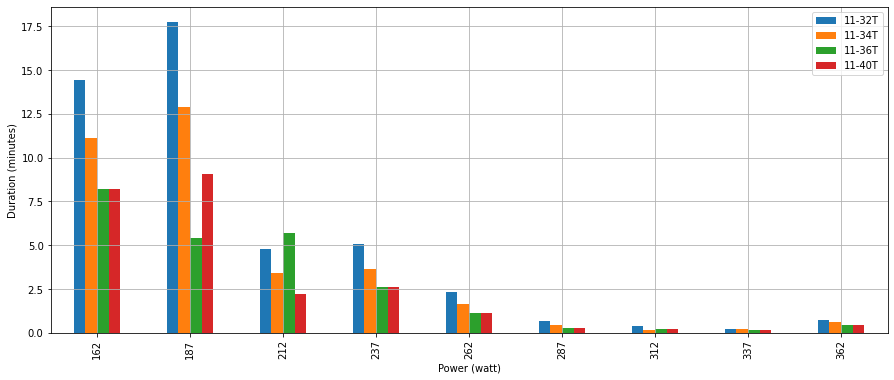

In [456]:
pp = pd.concat(pps, axis=1)
pp = pp.applymap(lambda t: t.total_seconds() / 60)

# IGNORE THE MINIMUM POWER
pp = pp.iloc[1:,:]
display(Markdown('Raw data:'))
display(pp)

W = 25
pp = pp.groupby(lambda p: (p // W * W) + (W//2)).agg('sum')
display(Markdown(f'Grouped by {W}w:'))
display(pp)

display(Markdown('Chart:'))
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = pp.plot.bar(ax=ax)
ax.grid()
ax.set_xlabel('Power (watt)')
ax.set_ylabel('Duration (minutes)')
plt.show()

## Torque distribution across different cassettes

In [457]:
def round_prec(n, precision):
    correction = 0.5 if n >= 0 else -0.5
    return int( n/precision+correction ) * precision

# Test
round_prec(1.86, 0.25)

1.75

,11-32T,11-34T,11-36T,11-40T
torque,,,,
2.0,18.500000,18.500000,38.050000,45.833333
2.5,19.550000,38.850000,19.300000,20.066667
3.0,39.366667,20.066667,37.200000,31.816667
3.5,17.133333,31.816667,26.433333,19.950000
4.0,24.950000,11.100000,8.200000,9.066667
4.5,7.216667,12.866667,5.416667,2.183333
5.0,4.766667,3.383333,5.683333,2.633333
5.5,5.066667,3.633333,2.616667,0.783333
6.0,1.483333,0.900000,0.783333,0.466667


Chart:

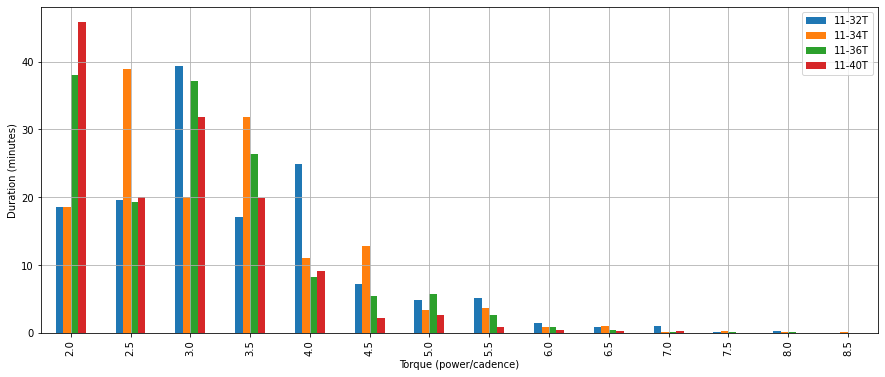

In [458]:
dfs = []
for df in torques:
    df = df.groupby(lambda torque: round_prec(torque, 0.5)).agg('sum')
    dfs.append(df)
    
df = pd.concat(dfs, axis=1)
df /= 60
df = df.loc[2.0:,:]
display(df)

display(Markdown('Chart:'))
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = df.plot.bar(ax=ax)
ax.grid()
ax.set_xlabel('Torque (power/cadence)')
ax.set_ylabel('Duration (minutes)')
plt.show()